(20,)


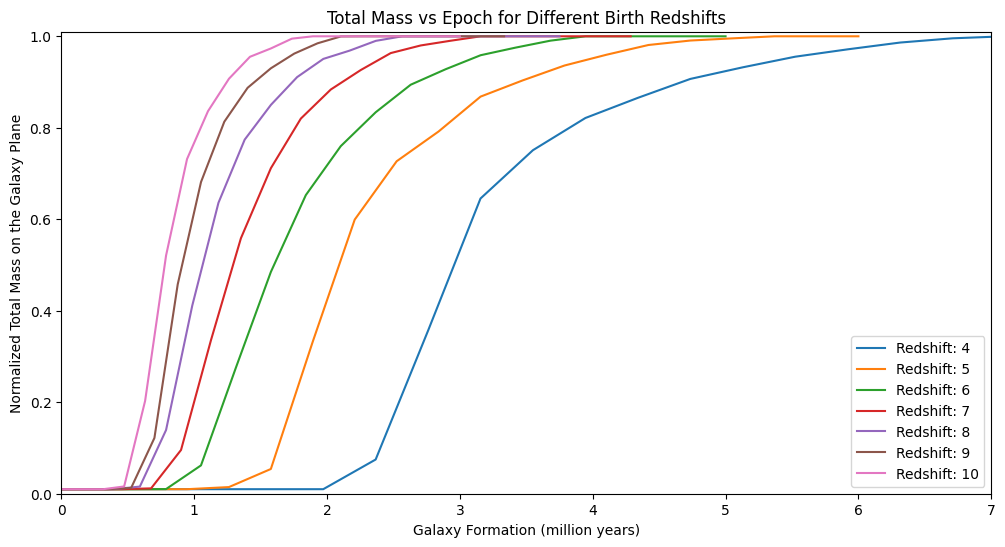

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt


def get_files_with_pattern(directory, pattern):
    files = [f for f in os.listdir(directory) if pattern in f]
    
    # Sort based on the extracted redshift value from the filename
    files_sorted = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    return files_sorted


def extract_redshift_from_filename(filename):
    return int(filename.split('_')[-1].split('.')[0])

def sum_masses_from_file(filename):
    data = np.load(filename)
    totalmasses = np.sum(data, axis=(1,2))
    massOnPlane = data[:,:,50]
    sumMassOnPlane = np.sum(massOnPlane, axis=1)/totalmasses
    return sumMassOnPlane # Summing over the 'radius' and 'elevation' axes

def plot_masses(masses_dict):
    plt.figure(figsize=(12,6))
    for redshift, masses in masses_dict.items():
        plt.plot(masses[0][:]/1e6,masses[1][:], label=f'Redshift: {redshift}')
    plt.legend(loc='lower right')
    plt.xlim(0,7)
    plt.ylim(0,1.01)
    plt.xlabel('Galaxy Formation (million years)')
    plt.ylabel('Normalized Total Mass on the Galaxy Plane')
    plt.title('Total Mass vs Epoch for Different Birth Redshifts')
    plt.savefig("./Figures/FreeFrallGalaxyFormation.png")
    plt.show()

def process_and_plot(directory):
    filenames = get_files_with_pattern(directory, '_freefall_all_current_masses_')
    
    masses_dict = {}  # To store summed masses for each redshift
    for filename in filenames:
        redshift = extract_redshift_from_filename(filename)
        epochs = np.load(directory + "/_freefall_epochs_"+ str(redshift) + '.npy')
        epochs = epochs - epochs[0]
        masses = sum_masses_from_file(os.path.join(directory, filename))
        masses_dict[redshift] = (epochs,masses)

    print(masses_dict[7][0].shape)
    plot_masses(masses_dict)
    return masses_dict

masses_dict = process_and_plot('./data')


For redshift 4, galaxy formation time: 2.99


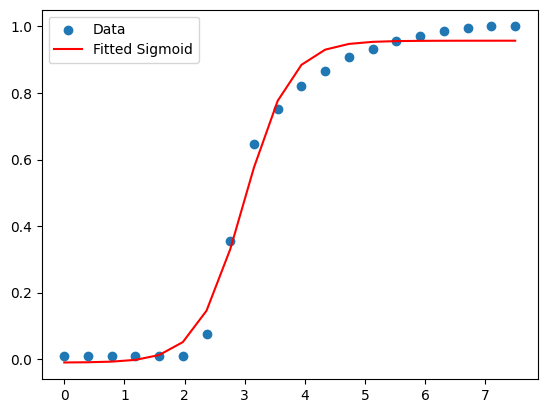

For redshift 5, galaxy formation time: 2.14


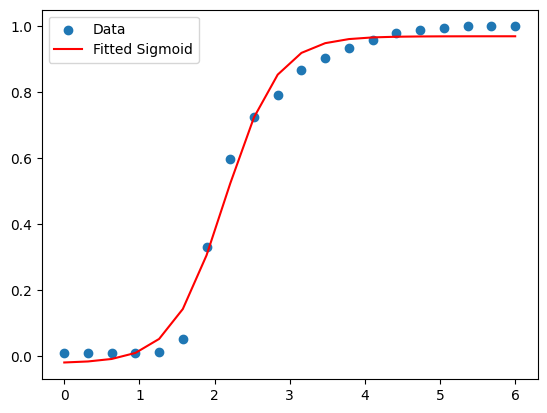

For redshift 6, galaxy formation time: 1.63


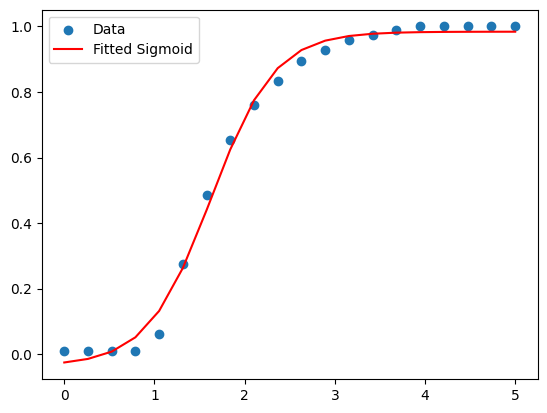

For redshift 7, galaxy formation time: 1.31


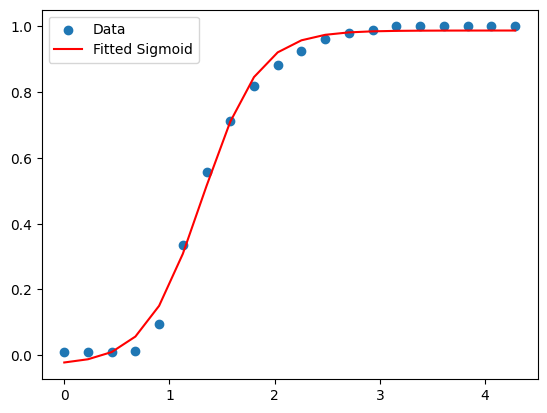

For redshift 8, galaxy formation time: 1.08


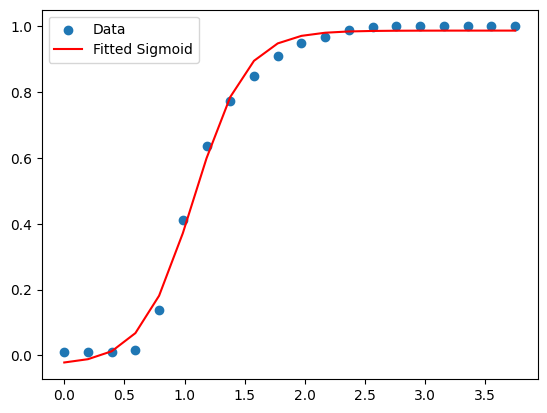

For redshift 9, galaxy formation time: 0.93


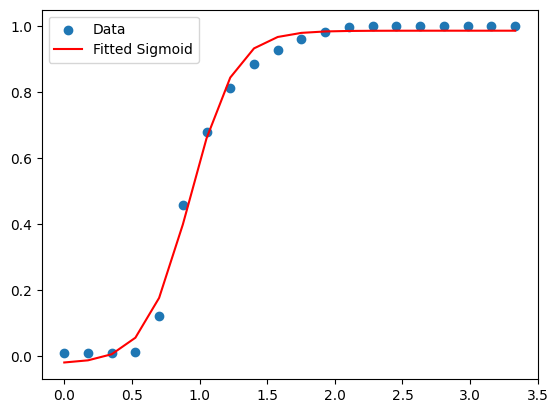

For redshift 10, galaxy formation time: 0.80


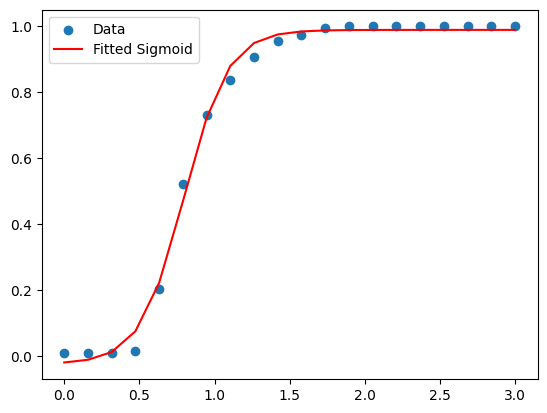

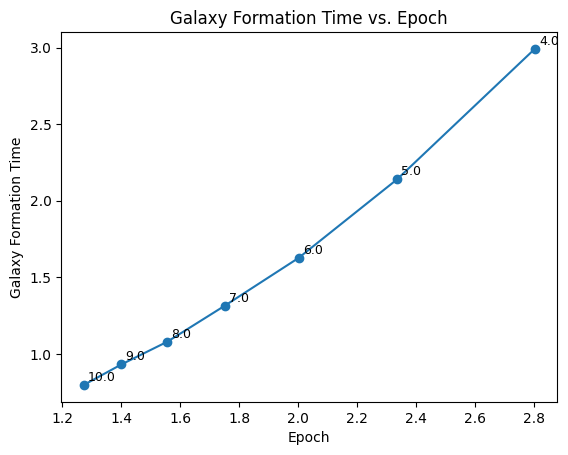

In [67]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x, x0, b, a, c):
    return a / (1.0 + np.exp(-b * (x - x0))) + c

# Simulate some data (You have your masses data)
# x = np.linspace(-10, 10, 100)
# y = 1 / (1 + np.exp(-x)) + 0.05 * np.random.normal(size=x.size)

# Your data:
# x = epochs for some redshift
# y = masses for the same redshift
galaxy_formation_time = {}
for z in np.arange(4,11):
    # Fit the data to the sigmoid function
    a10 = masses_dict[z]
    x = a10[0]/1E6
    y = a10[1]
    params, covariance = curve_fit(sigmoid, x, y, p0=[np.median(x), 1, 1,0])

    # Extract the galaxy formation time (x0 parameter)
    galaxy_formation_time[z] = (z, 14.01/(1+z), params[0])

    print(f"For redshift {z}, galaxy formation time: {params[0]:.2f}")

    # Plot the data and the fit
    plt.scatter(x, y, label='Data')
    plt.plot(x, sigmoid(x, *params), color='red', label='Fitted Sigmoid')
    plt.legend()
    plt.show()

# Convert the dictionary to a DataFrame
import pandas as pd
df = pd.DataFrame.from_dict(galaxy_formation_time, orient='index', columns=["redshift", "Epoch", "FormationTime"])

# Plot the formation time vs. epoch
ax = df.plot(x="Epoch", y="FormationTime", marker='o', linestyle='solid', legend=False)  # linestyle='' ensures only points are plotted
plt.xlabel('Epoch')
plt.ylabel('Galaxy Formation Time')
plt.title('Galaxy Formation Time vs. Epoch')

# Annotate each point with its redshift
for idx, row in df.iterrows():
    ax.annotate(f"{row['redshift']:.1f}", (row['Epoch'], row['FormationTime']), fontsize=9, xytext=(3,3), textcoords='offset points')
plt.savefig("./Figures/FreeFrallGalaxyFormationFittedTime.png")
plt.show()